# ARIMA Model - Median Hourly Wage ($)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

## Packages

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import gdown
import requests
import warnings
from io import StringIO

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Show graphs
%matplotlib inline

## Data Loading

In [3]:
# Google Drive file
file_id = '1RpF3UtvdnvwGilvP5KjQ2tA-hHDNKsnc'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status() 

# Load the CSV directly into df
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

# Display data
print('Shape of the dataset:', df.shape)
print(df.dtypes)

Shape of the dataset: (349920, 13)
Unnamed: 0              int64
ref_date               object
geo                    object
labour_force           object
industry               object
sex                    object
age_group              object
value_unemployment    float64
wages                  object
value_wage            float64
year                    int64
month                   int64
ref_date_numeric      float64
dtype: object


In [4]:
# Create a copy with selected columns
df_var = df[['ref_date', 'value_wage']].copy()

print(df_var.head())

     ref_date  value_wage
0  1997-01-01        7.00
1  1997-01-01        8.00
2  1997-01-01        7.50
3  1997-01-01        7.00
4  1997-01-01        9.49


In [5]:
# Group df_var by 'ref_date' and calculate the median 'value_wage'
df_arima = df_var.groupby('ref_date').agg(
    median_wage=('value_wage', 'median')  # Calculate the median 
).reset_index()

print(df_arima)

       ref_date  median_wage
0    1997-01-01    12.375000
1    1997-02-01    12.695000
2    1997-03-01    12.511667
3    1997-04-01    12.585000
4    1997-05-01    12.000000
..          ...          ...
319  2023-08-01    26.037639
320  2023-09-01    27.000000
321  2023-10-01    26.670000
322  2023-11-01    27.000000
323  2023-12-01    27.400000

[324 rows x 2 columns]


In [6]:
# Display shape and data types
print('Shape of the dataset:\n', df_var.shape)
print(df_arima.dtypes)

# Convert 'ref_date' to datetime
df_arima['ref_date'] = pd.to_datetime(df_arima['ref_date'])

# Set 'ref_date' as the index 
df_arima = df_arima.set_index('ref_date')

# Verify the index is set and DatetimeIndex
print('\n\nIndex after setting ref_date:\n', df_arima.head().index)
print('\n\nData types after setting index:\n', df_arima.dtypes)
print('\n\nDataset:\n', df_arima.head(2))

Shape of the dataset:
 (349920, 2)
ref_date        object
median_wage    float64
dtype: object


Index after setting ref_date:
 DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01'],
              dtype='datetime64[ns]', name='ref_date', freq=None)


Data types after setting index:
 median_wage    float64
dtype: object


Dataset:
             median_wage
ref_date               
1997-01-01       12.375
1997-02-01       12.695


# Visualization

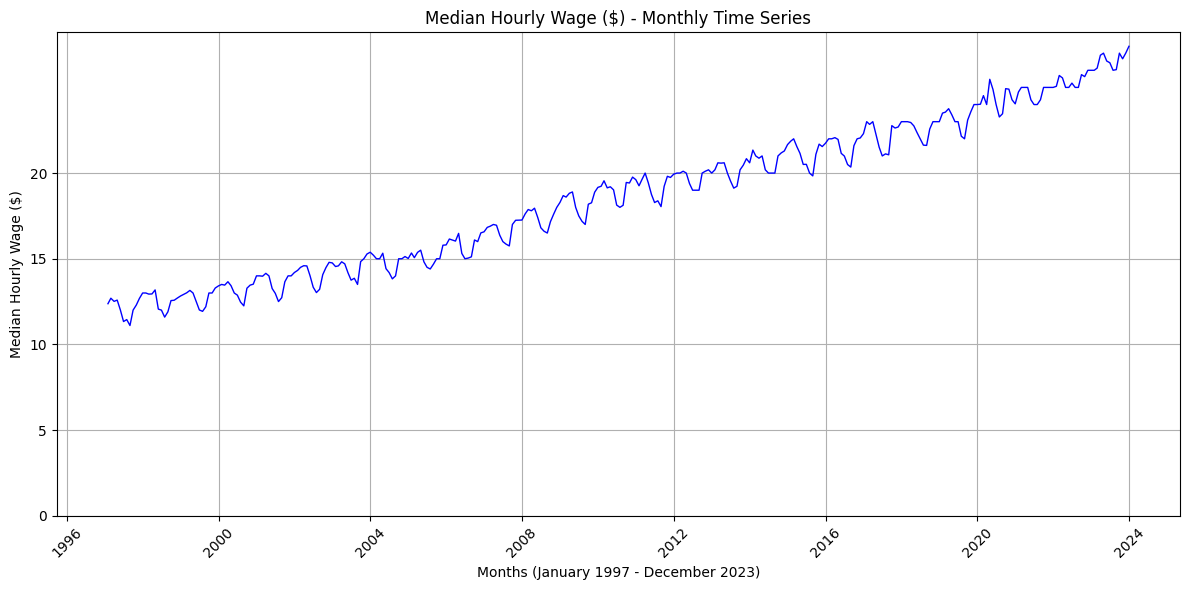

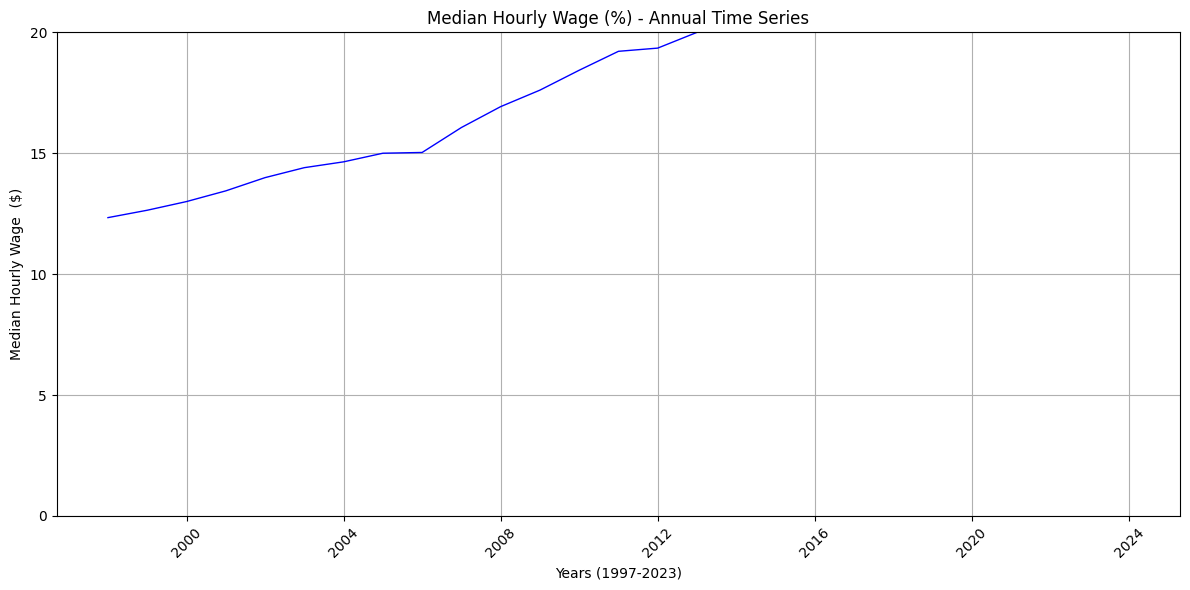

In [7]:
# Resampling to monthly 
df_monthly = df_arima.resample('ME').median()

# Resampling to yearly 
df_annual = df_arima.resample('YE').median()

# Set y-axis limits and tick intervals
y_min = 0
y_max = 20
y_ticks = range(y_min, y_max + 1, 5)

# Plot the monthly median hourly wage
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, color='blue', linewidth=1)
plt.title('Median Hourly Wage ($) - Monthly Time Series')
plt.xlabel('Months (January 1997 - December 2023)')
plt.ylabel('Median Hourly Wage ($)')
plt.xticks(rotation=45)
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the yearly median hourly wage
plt.figure(figsize=(12, 6))
plt.plot(df_annual.index, df_annual, color='blue', linewidth=1)
plt.title('Median Hourly Wage (%) - Annual Time Series')
plt.xlabel('Years (1997-2023)')
plt.ylabel('Median Hourly Wage  ($)')
plt.xticks(rotation=45)
plt.ylim(y_min, y_max)
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()


# Stationarity

## ADF

Augmented Dickey-Fuller (ADF) Test

In [8]:
# Perform ADF test 
adf_test = adfuller(df_arima)
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing may be required.")


ADF Test Results:
ADF Statistic: 2.116022002061713
p-value: 0.998805980482922
The data is not stationary. Differencing may be required.


## Differencing

In [9]:
# First-order differencing
df_arima_diff = df_arima.diff().dropna()

# Check differenced data
print(df_arima_diff.head())

            median_wage
ref_date               
1997-02-01     0.320000
1997-03-01    -0.183333
1997-04-01     0.073333
1997-05-01    -0.585000
1997-06-01    -0.665000


In [10]:
# Re-run ADF test with differenced data
result = adfuller(df_arima_diff['median_wage'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is still not stationary. Further transformation may be required.")

ADF Statistic: -4.659650176467592
p-value: 0.00010013395274502792
The data is stationary.


## ACF & PACF

Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

Data Summary:
       median_wage
count   324.000000
mean     18.589238
std       4.331917
min      11.102143
25%      14.590625
50%      18.949167
75%      22.000000
max      27.400000


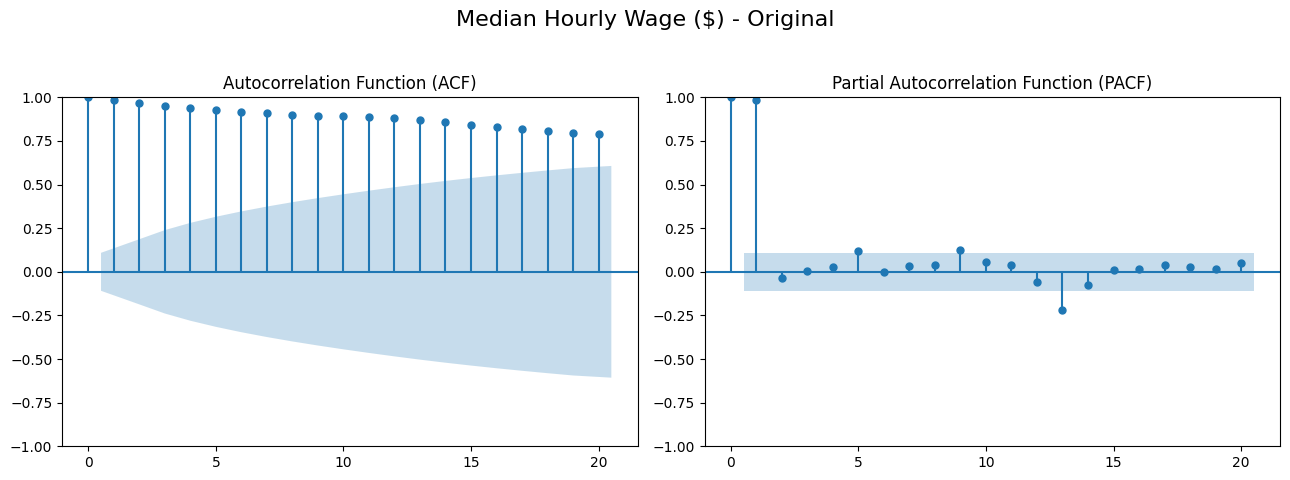

In [11]:
# Define function 
def acf_pacf_plotter(data, nlag=15, alpha=0.05, fig_size=(13, 5)):
        # Check and print descriptives
    print("Data Summary:")
    print(data.describe())

    # Create figure
    plt.figure(figsize=fig_size)
    layout = (1, 2)  

    # Assign axes 
    ax_acf = plt.subplot2grid(layout, (0, 0))  # Left side for ACF
    ax_pacf = plt.subplot2grid(layout, (0, 1))  # Right side for PACF

    # Plot ACF and PACF 
    plot_acf(data, alpha=alpha, lags=nlag, ax=ax_acf)
    plot_pacf(data, alpha=alpha, lags=nlag, ax=ax_pacf)

    # Set titles
    ax_acf.set_title('Autocorrelation Function (ACF)')
    ax_pacf.set_title('Partial Autocorrelation Function (PACF)')

    # Add figure title
    plt.suptitle('Median Hourly Wage ($) - Original', fontsize=16)

    # Adjust layout 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show figure
    plt.show()

# Use Function with data
acf_pacf_plotter(df_arima, nlag=20)


Data Summary:
       median_wage
count   323.000000
mean      0.046517
std       0.460303
min      -1.170000
25%      -0.199152
50%       0.005000
75%       0.269458
max       1.702738


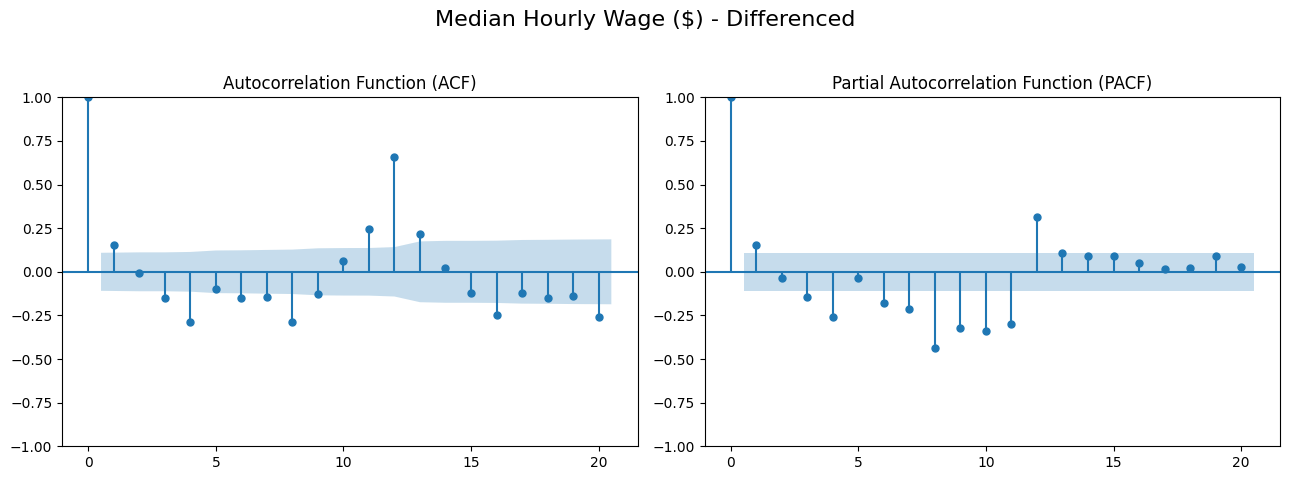

In [12]:
# Define function 
def acf_pacf_plotter(data, nlag=15, alpha=0.05, fig_size=(13, 5)):
        # Check and print descriptives
    print("Data Summary:")
    print(data.describe())

    # Create figure
    plt.figure(figsize=fig_size)
    layout = (1, 2)  

    # Assign axes 
    ax_acf = plt.subplot2grid(layout, (0, 0))  # Left side for ACF
    ax_pacf = plt.subplot2grid(layout, (0, 1))  # Right side for PACF

    # Plot ACF and PACF 
    plot_acf(data, alpha=alpha, lags=nlag, ax=ax_acf)
    plot_pacf(data, alpha=alpha, lags=nlag, ax=ax_pacf)

    # Set titles
    ax_acf.set_title('Autocorrelation Function (ACF)')
    ax_pacf.set_title('Partial Autocorrelation Function (PACF)')

    # Add figure title
    plt.suptitle('Median Hourly Wage ($) - Differenced', fontsize=16)

    # Adjust layout 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show figure
    plt.show()

# Use Function with data
acf_pacf_plotter(df_arima_diff, nlag=20)


## **Stationarity Conclusion**

The ADF test results indicate that the data is not stationary (> *p* = .05). This conclusion is also supported by the ACF plot, showing consistent, strong associations across all lags. Therefore, the data was differenced to better fit an ARIMA model. 

# ARIMA Parameters

In [13]:
warnings.filterwarnings("ignore")

data = df_arima

# Define the p, d, q parameter ranges 
p = range(0, 3) # Autoregressive  
d = range(0, 2) # Differencing 
q = range(0, 3) # Moving average 

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Initialize variables to store best AIC value and best parameter set
best_aic = float("inf")
best_pdq = None

# Grid Search: Iterate through combinations of p, d, q
for param in pdq:
    try:
        # Fit ARIMA model 
        model = ARIMA(data, order=param)
        model_fit = model.fit()
        
        # Evaluate using AIC 
        current_aic = model_fit.aic
        
        # Store lowest AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_pdq = param
            
        # Print iteration result 
        print(f"ARIMA{param} AIC: {current_aic:.2f}")

    except Exception as e:
        # Print error 
        print(f"Error for ARIMA{param}: {e}")
        continue

# Print best model parameters and lowest AIC
if best_pdq:
    print(f"\nBest ARIMA model: {best_pdq} with AIC: {best_aic:.2f}")
else:
    print("\nNo valid ARIMA model was found.")


ARIMA(0, 0, 0) AIC: 1872.45
ARIMA(0, 0, 1) AIC: 1469.07
ARIMA(0, 0, 2) AIC: 1179.85
ARIMA(0, 1, 0) AIC: 419.71
ARIMA(0, 1, 1) AIC: 413.47
ARIMA(0, 1, 2) AIC: 415.08
ARIMA(1, 0, 0) AIC: 430.03
ARIMA(1, 0, 1) AIC: 423.58
ARIMA(1, 0, 2) AIC: 425.09
ARIMA(1, 1, 0) AIC: 413.43
ARIMA(1, 1, 1) AIC: 415.34
ARIMA(1, 1, 2) AIC: 399.00
ARIMA(2, 0, 0) AIC: 423.48
ARIMA(2, 0, 1) AIC: 425.41
ARIMA(2, 0, 2) AIC: 426.48
ARIMA(2, 1, 0) AIC: 415.22
ARIMA(2, 1, 1) AIC: 389.77
ARIMA(2, 1, 2) AIC: 304.16

Best ARIMA model: (2, 1, 2) with AIC: 304.16


In [14]:
warnings.filterwarnings("ignore")

data = df_arima

# Define the p, d, q parameter ranges 
p = range(0, 3)  # Autoregressive 
d = range(0, 2)  # Differencing
q = range(0, 3)  # Moving average 

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Initialize variables to store best BIC value and best parameter set
best_bic = float("inf")
best_pdq = None

# Grid Search: Iterate through combinations of p, d, q
for param in pdq:
    try:
        # Fit ARIMA model 
        model = ARIMA(data, order=param)
        model_fit = model.fit()

        # Evaluate using BIC
        current_bic = model_fit.bic

        # Store lowest BIC
        if current_bic < best_bic:
            best_bic = current_bic
            best_pdq = param

        # Print iteration result
        print(f"ARIMA{param} BIC: {current_bic:.2f}")

    except Exception as e:
        # Skip models that fail to converge or cause errors
        print(f"Error for ARIMA{param}: {e}")
        continue

# Print best model parameters and lowest BIC 
if best_pdq:
    print(f"\nBest ARIMA model: {best_pdq} with BIC: {best_bic:.2f}")
else:
    print("\nNo valid ARIMA model was found.")


ARIMA(0, 0, 0) BIC: 1880.01
ARIMA(0, 0, 1) BIC: 1480.41
ARIMA(0, 0, 2) BIC: 1194.98
ARIMA(0, 1, 0) BIC: 423.49
ARIMA(0, 1, 1) BIC: 421.03
ARIMA(0, 1, 2) BIC: 426.41
ARIMA(1, 0, 0) BIC: 441.38
ARIMA(1, 0, 1) BIC: 438.70
ARIMA(1, 0, 2) BIC: 443.99
ARIMA(1, 1, 0) BIC: 420.98
ARIMA(1, 1, 1) BIC: 426.68
ARIMA(1, 1, 2) BIC: 414.11
ARIMA(2, 0, 0) BIC: 438.61
ARIMA(2, 0, 1) BIC: 444.32
ARIMA(2, 0, 2) BIC: 449.17
ARIMA(2, 1, 0) BIC: 426.55
ARIMA(2, 1, 1) BIC: 404.88
ARIMA(2, 1, 2) BIC: 323.05

Best ARIMA model: (2, 1, 2) with BIC: 323.05


**Autoregressive** **(AR)**

AIC/BIC = 2

*p* = 2

<br>

**Integrated** **(I)**

ADF Test - data was not stationary. Differencing was applied once. 

AIC/BIC = 1

*d* = 1

<br>

**Moving Average** **(MA)**

AIC/BIC = 2

*q* = 2

---

**Model Results**

ARIMA(2,1,2)

## Assign Training & Testing Sets

In [15]:
# Split into training and testing sets
train = df_arima['1997-01-01':'2020-12-01']
test = df_arima['2021-01-01':'2023-12-01']

print(train.head())
print(train.tail())

            median_wage
ref_date               
1997-01-01    12.375000
1997-02-01    12.695000
1997-03-01    12.511667
1997-04-01    12.585000
1997-05-01    12.000000
            median_wage
ref_date               
2020-08-01    23.463571
2020-09-01    24.927500
2020-10-01    24.897857
2020-11-01    24.281875
2020-12-01    24.040000


# ARIMA Model

## Fit Model

In [16]:
p = 2
d = 1
q = 2

# Fit ARIMA model 
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            median_wage   No. Observations:                  288
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -132.994
Date:                Wed, 13 Nov 2024   AIC                            275.988
Time:                        23:53:57   BIC                            294.286
Sample:                    01-01-1997   HQIC                           283.322
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6748      0.021     78.757      0.000       1.633       1.716
ar.L2         -0.9214      0.028    -32.657      0.000      -0.977      -0.866
ma.L1         -1.8272      0.026    -70.713      0.0

## Cross Validation

In [17]:
# Define procedure
tscv = TimeSeriesSplit(n_splits=5)

# Assign training data
train_series = train['median_wage']
train_series.index = train_series.index.to_period('M').to_timestamp()

# Cross-validation
cv_mse_scores = []
cv_rmse_scores = []
cv_mae_scores = []
cv_mape_scores = []

for train_index, val_index in tscv.split(train_series):
    # Split into train and validation sets
    train_cv, val_cv = train_series.iloc[train_index], train_series.iloc[val_index]

    # Fit the ARIMA model (d=1 -> data not stationary)
    model = ARIMA(train_cv, order=(2, 1, 2))
    model_fit = model.fit()

    # Forecast for the length of validation set
    forecast = model_fit.forecast(steps=len(val_cv))

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(val_cv, forecast)
    cv_mse_scores.append(mse)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    cv_rmse_scores.append(rmse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(val_cv, forecast)
    cv_mae_scores.append(mae)

    # Calculate Mean Absolute Percentage Error (MAPE)
    epsilon = 1e-10
    
    # Convert to numpy arrays 
    val_cv_np = val_cv.values
    forecast_np = forecast.values

    # Filter out zero or near-zero values 
    valid_indices = val_cv_np > epsilon
    filtered_val_cv = val_cv_np[valid_indices]
    filtered_forecast = forecast_np[valid_indices]

    if len(filtered_val_cv) > 0:
        # MAPE calculation
        mape = np.mean(np.abs((filtered_val_cv - filtered_forecast) / (filtered_val_cv + epsilon))) * 100
    else:
        mape = np.nan  # If no valid values, set as NaN

    cv_mape_scores.append(mape)

# Cross-validation scores
print('Cross-Validation Mean Squared Error (MSE):', np.mean(cv_mse_scores))
print('Cross-Validation Root Mean Squared Error (RMSE):', np.mean(cv_rmse_scores))
print('Cross-Validation Mean Absolute Error (MAE):', np.mean(cv_mae_scores))
print('Cross-Validation Mean Absolute Percentage Error (MAPE):', np.nanmean(cv_mape_scores))  # Use np.nanmean to ignore NaNs


Cross-Validation Mean Squared Error (MSE): 1.6497677240473458
Cross-Validation Root Mean Squared Error (RMSE): 1.244790616024908
Cross-Validation Mean Absolute Error (MAE): 1.037728216018294
Cross-Validation Mean Absolute Percentage Error (MAPE): 5.4676476068162305


In [18]:
# ARIMA Model
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecast using the final model
forecast = model_fit.forecast(steps=len(test))

# Print forecast 
print(forecast.head()) 

# Align the forecast index to the test index
forecast.index = test.index  

# Add forecast to the test data
test = test.copy()  
test['Predicted'] = forecast

2021-01-01    24.344745
2021-02-01    24.657444
2021-03-01    24.900343
2021-04-01    25.019010
2021-05-01    24.993938
Freq: MS, Name: predicted_mean, dtype: float64


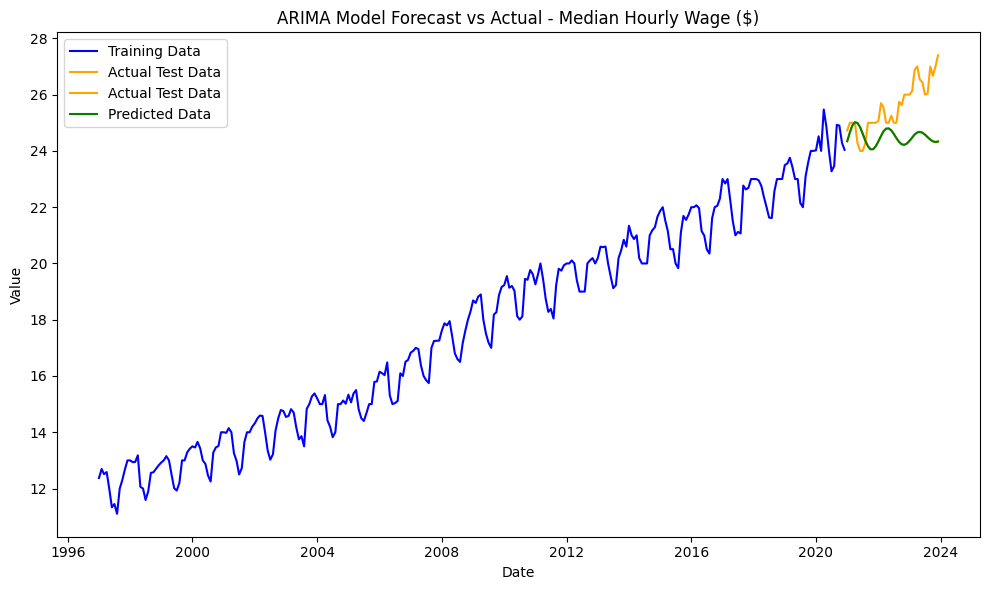

In [19]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data', color='blue', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', color='orange', linewidth=1.5)
plt.plot(test.index, test['Predicted'], label='Predicted Data', color='green', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast vs Actual - Median Hourly Wage ($)')
plt.legend()
plt.tight_layout()  
plt.show()


Mean Squared Error (MSE): 2.0768426933070305
Root Mean Squared Error (RMSE): 1.441125495335861
Mean Absolute Error (MAE): 1.1907457105341086
Mean Absolute Percentage Error (MAPE): 4.565617786314573


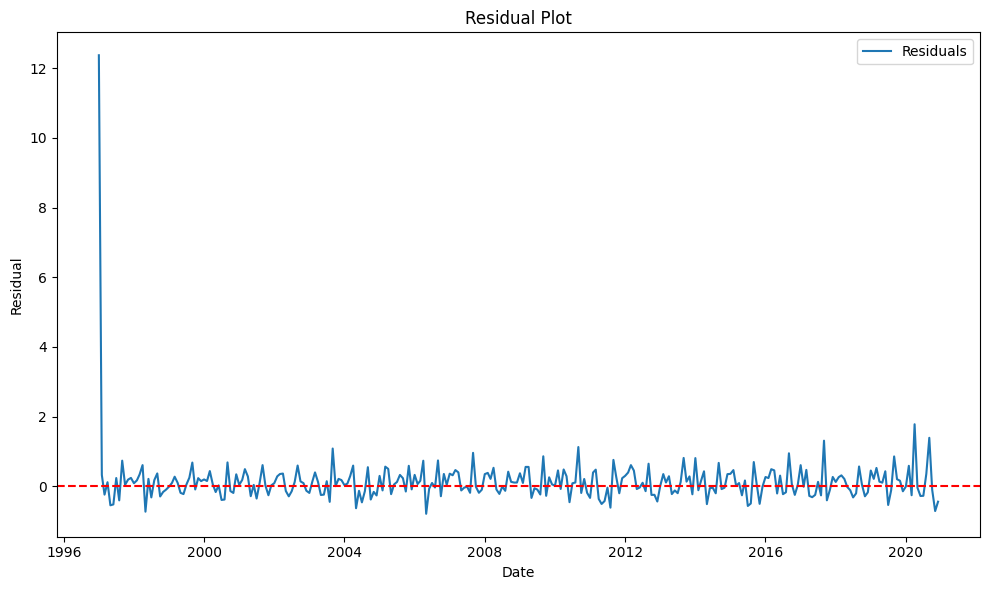

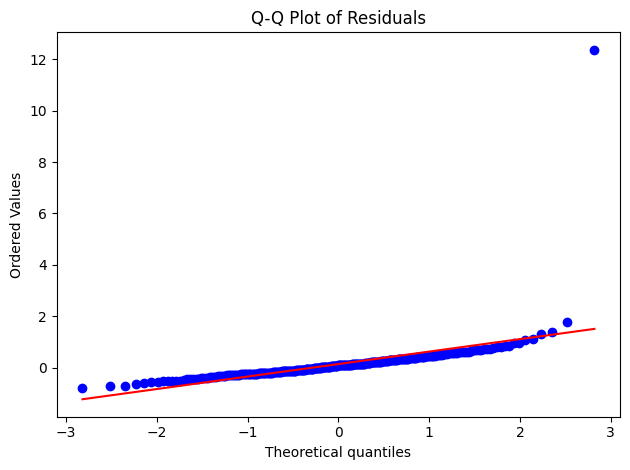

In [20]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['median_wage'], test['Predicted'])
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test['median_wage'], test['Predicted'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10  
filtered_test_data = test[test['median_wage'] > epsilon]  # Filter out values that are zero or near-zero
filtered_actual = filtered_test_data['median_wage']
filtered_predicted = filtered_test_data['Predicted']

if len(filtered_actual) > 0:
    mape = np.mean(np.abs((filtered_actual - filtered_predicted) / (filtered_actual + epsilon))) * 100
else:
    mape = np.nan

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.legend()
plt.tight_layout()
plt.show()

# Q-Q plot for normality check
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
